In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import torch
import pywt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from src.algorithms import *
from src.datalib import *
from scipy.ndimage import gaussian_filter

from tqdm import tqdm
%matplotlib widget

In [2]:
wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

def wavelet_denoise(image, wavelet, level, factor, clip = False):
    coeffs = pywt.wavedec2(image, wavelet, level = level)

    sigma = np.median(np.abs(coeffs[-1][0])) / factor
    threshold = sigma * np.sqrt(2 * np.log(image.size))

    coeffs[1:] = [[pywt.threshold(c, value=threshold, mode='soft') for c in detail] for detail in coeffs[1:]]
    denoised_image = pywt.waverec2(coeffs, wavelet)
    
    if clip:
        denoised_image = np.clip(denoised_image, 0, 255)
        denoised_image = denoised_image.astype(np.uint8)
    
    return denoised_image

# 1. Load LIBS Dataset

In [3]:
file_libs_metadata = r'E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines


In [4]:
libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

getting map dimensions


# 2. Create RGB Images

To create RGB images from LIBS we combine 3 spectral maps and stack them in an array of shape (x, y, 3). For this particular dataset, the LIBS maps must be presented in logscale for information to be visible, so we need to perform extra processing to each spectral map. For that we will explore methods such as histogram equalization.

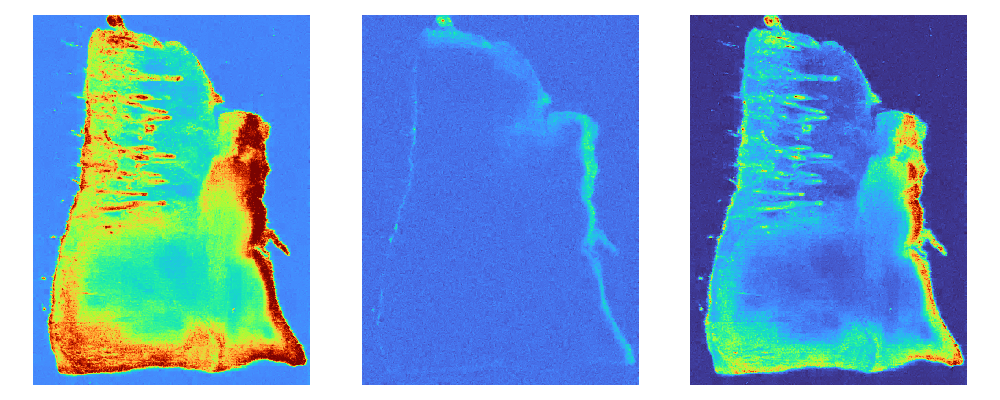

In [5]:
wavelet = 'db1'
level = 8
factor = 4
lines = [393.36, 324.825, 396.833]

fig, axs = plt.subplots(1, 3, figsize = (10, 4))

for i, line in enumerate(lines):
    ax = axs[i]
    image = spectrum[:, :, wavelength_to_index(line, wavelengths)]
    image = wavelet_denoise(image, wavelet, level, factor, clip = True)
    ax.imshow(
        image,
        cmap = 'turbo',
        #norm = colors.LogNorm(),
        )
    ax.axis('off')
fig.tight_layout()

## 2.1 Create RGB array

Two of the lines we are using seem to represent the same elemeent. While this might be suitable for HDR image processing of various emission lines, is is inadequate for RGB imaging, since it won't provie distinct signatures to each channel and the final image will either look like it is in grayscale, or like it is color shifted to the dominant (higher intensity) emission line. Then we must find a suitable algorithm to identify spectral emission lines. Some possible approaches can be:

1. Spectral clustering (correlation metric)
1. FFT feature extraction
1. ...

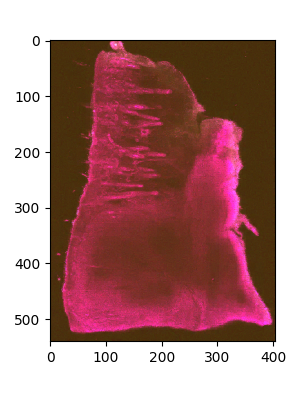

In [6]:
rgb_libs = np.transpose(
    np.array([wavelet_denoise(spectrum[:, :, wavelength_to_index(line, wavelengths)], 
                            wavelet, 
                            level, 
                            factor, 
                            clip = True)
            for line in lines]),
            axes = (1, 2, 0))

fig, ax = plt.subplots(figsize = (3, 4))

ax.imshow(rgb_libs)

fig.tight_layout()

# 3. Spectral Clustering

In [23]:
%autoreload 1
%autoreload 2

In [36]:
sg = 0
step = 3
num_clusters = 6
flat_spec = cp.array(gaussian_filter(spectrum[::step, ::step], sigma = sg), copy = True).reshape(-1, spectrum.shape[-1]).T

kmeans = GPUKMeans(n_clusters = num_clusters, distance = 'correlation', random_state = 10, verbose = True)
kmeans.fit(flat_spec)

Initializations: 100%|██████████| 10/10 [01:46<00:00, 10.63s/it, Best inertia=3460.3882]


In [37]:
centroids = kmeans.get_cluster_centers().reshape(num_clusters, spectrum[::step, ::step].shape[0], spectrum[::step, ::step].shape[1])

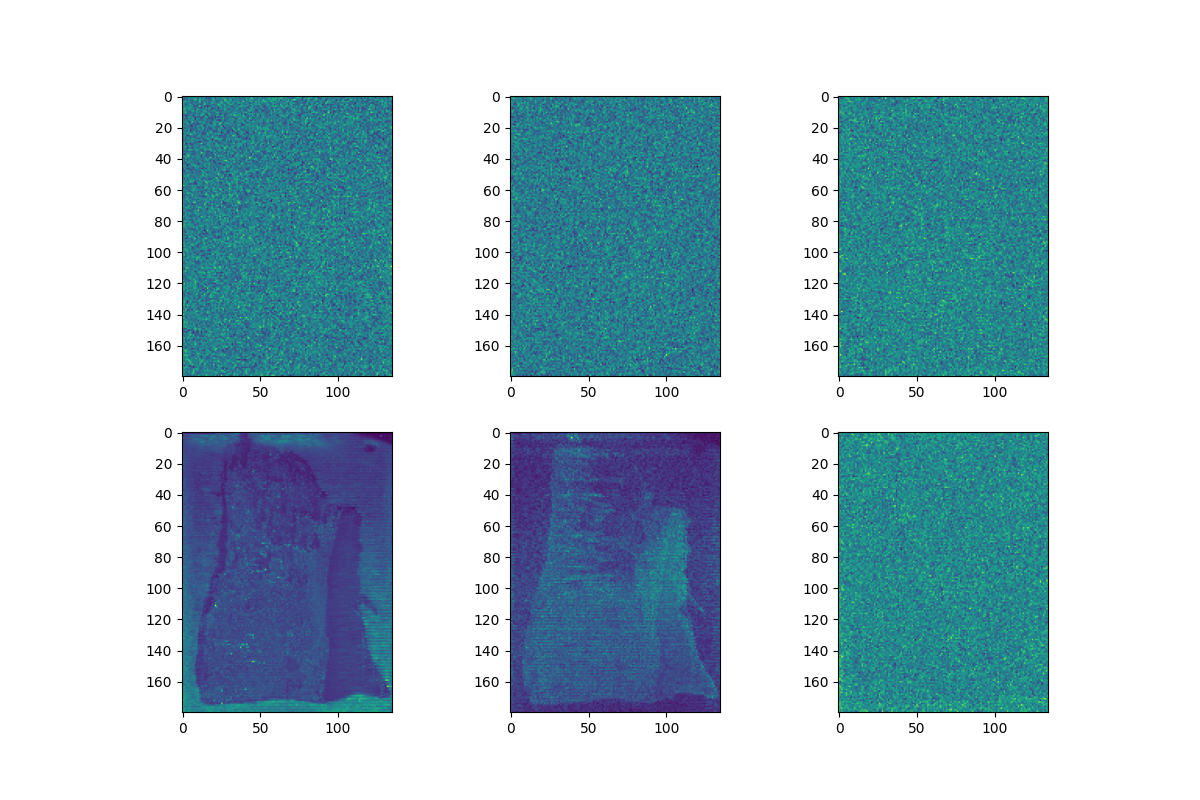

In [38]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))

axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(centroids[i])